## Summary

---

## Imports

In [1]:
from pathlib import Path

import tqdm
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import lightgbm as lgb
from scipy import stats
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [2]:
pd.set_option("max_rows", 1000)
pd.set_option("max_columns", 1000)

## Parameters

In [3]:
NOTEBOOK_NAME = "bayesian-linear-regression"
NOTEBOOK_PATH = Path(NOTEBOOK_NAME).resolve()
NOTEBOOK_PATH.mkdir(exist_ok=True)
NOTEBOOK_NAME

'bayesian-linear-regression'

## Load data

In [4]:
input_df = pq.read_table("01_prepare_combined_dataset/combined.parquet").to_pandas()

In [5]:
# input_df = pq.read_table("data-challenge/data_final2.parquet").to_pandas()

## Filter data

In [6]:
input_df["y"] = input_df[["acq2", "acq3", "acq4", "acq5"]].mean(axis=1) - input_df["acq"]

In [7]:
input_df = input_df[input_df["y"].notnull()]
input_df = input_df[
    (input_df[["acq", "acq2", "acq3", "acq4", "acq5"]] <= 6).all(axis=1)
]

In [8]:
assert len(input_df) == 143, len(input_df)

## Explore input data

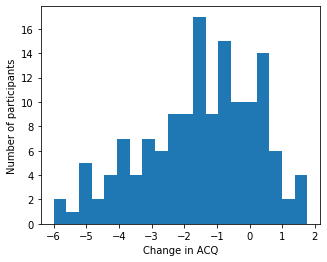

In [9]:
fg, ax = plt.subplots(figsize=(5, 4))
ax.hist(input_df["y"], bins=20)
ax.set_xlabel("Change in ACQ")
ax.set_ylabel("Number of participants")
None

In [10]:
input_df.columns

Index(['id', 'date_x', 'acq', 'date2', 'acq2', 'date3', 'acq3', 'date4',
       'acq4', 'date5', 'acq5', 'co-copd', 'co-heartfailure', 'co-diabetes',
       'co-yellowfever', 'co-asthma', 'co-pulmonaryembolism', 'co-bronchitis',
       'co-arthritis', 'co-pneumonia', 'medhistory_table', 'assess', 'smoking',
       'polyps', 'vaccine', 'arthritis', 'CVD', 'Prev-biologic', 'allergy',
       'weight', 'height', 'bmi', 'age', 'race', 'gender', 'work', 'retire',
       'disab', 'demographics_table', 'sex', 'date_y', 'clinic', 'infconsent',
       '18+', 'eos300', 'eos150', 'sputum', 'acq-screen', 'result', 'y'],
      dtype='object')

In [11]:
def compute_correlations(df, target_col):
    corrs = []
    for col in df._get_numeric_data():
        if col == target_col:
            continue
        df_subset = df[[col, target_col]].dropna()
        corr = stats.spearmanr(df_subset[col], df_subset[target_col])
        corrs.append((target_col, col) + tuple(corr))
    df = pd.DataFrame(corrs, columns=["col1", "col2", "corr", "pvalue"])
    df = df.sort_values("pvalue", ascending=True)
    return df

In [12]:
compute_correlations(input_df, 'y')

/home/ubuntu/anaconda3/envs/defaults-v1/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/ubuntu/anaconda3/envs/defaults-v1/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/ubuntu/anaconda3/envs/defaults-v1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/ubuntu/anaconda3/envs/defaults-v1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/ubuntu/anaconda3/envs/defaults-v1/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


,col1,col2,corr,pvalue
5,y,acq5,0.663667,1.672047e-19
4,y,acq4,0.646168,2.908548e-18
3,y,acq3,0.624139,8.222309e-17
2,y,acq2,0.610862,5.439628e-16
1,y,acq,-0.567981,1.382140e-13
28,y,gender,-0.396433,6.776397e-02
30,y,retire,-0.199471,9.298206e-02
20,y,arthritis,0.151384,1.213696e-01
19,y,vaccine,-0.150725,1.230172e-01
21,y,CVD,0.141872,1.468661e-01


## Fit model

In [13]:
def encode_categorical(df, column):
    categories = {c: i for i, c in enumerate(set(df[column]))}
    df[column] = df[column].map(categories)

In [14]:
def iter_grid_params(grid_params):
    if not grid_params:
        return [{}]
    grid_params = grid_params.copy()
    key, values = grid_params.popitem()
    result = []
    for child_dict in iter_grid_params(grid_params):
        for value in values:
            result.append({**child_dict, key: value})
    return result

In [15]:
columns_to_drop = [
    #
    "id",
    "date_x",
    "date_y",
    "acq",
    "date2",
    "acq2",
    "date3",
    "acq3",
    "date4",
    "acq4",
    "date5",
    "acq5",
    "assess",
    "date_x",
    "date_y",
    "clinic",
    "infconsent",
    "18+",
    #     "eos300",
    "eos150",
    "sputum",
    "acq-screen",
    "result",
]
data_df = input_df.drop(pd.Index(columns_to_drop), axis=1)

In [16]:
# columns_to_keep = [
#     "y", "retire", "arthritis", "vaccine",
# ]
# data_df = data_df[columns_to_keep]

In [17]:
categorical_feature=[
    "medhistory_table",
    "race",
    "ethnicity",
    "work",
    "disab",
    "demographics_tabl",
    "clinic",
    "infconsent",
    "18+",
    "result",
]
categorical_feature = [c for c in categorical_feature if c in data_df]
for column in categorical_feature:
    encode_categorical(data_df, column)
    
categorical_feature

['medhistory_table', 'race', 'work', 'disab']

### Prepare LGB datasets

In [18]:
data_df.columns

Index(['co-copd', 'co-heartfailure', 'co-diabetes', 'co-yellowfever',
       'co-asthma', 'co-pulmonaryembolism', 'co-bronchitis', 'co-arthritis',
       'co-pneumonia', 'medhistory_table', 'smoking', 'polyps', 'vaccine',
       'arthritis', 'CVD', 'Prev-biologic', 'allergy', 'weight', 'height',
       'bmi', 'age', 'race', 'gender', 'work', 'retire', 'disab',
       'demographics_table', 'sex', 'eos300', 'y'],
      dtype='object')

In [19]:
lgb_train_test_splits = []

kf = KFold(n_splits=10, shuffle=True, random_state=42)
for train_index, test_index in kf.split(data_df):
    train_df = data_df.iloc[train_index]
    test_df = data_df.iloc[test_index]
    X_train = train_df.drop("y", axis=1)
    y_train = train_df["y"]
    X_test = test_df.drop("y", axis=1)
    y_test = test_df["y"]
    lgb_train = lgb.Dataset(
        X_train, y_train, categorical_feature=categorical_feature, free_raw_data=False
    )
    lgb_test = lgb.Dataset(
        X_test,
        y_test,
        reference=lgb_train,
        categorical_feature=categorical_feature,
        free_raw_data=False,
    )
    lgb_train_test_splits.append((lgb_train, lgb_test))

lgb_full = lgb.Dataset(
    data_df.drop("y", axis=1),
    data_df["y"],
    categorical_feature=categorical_feature,
    free_raw_data=False,
)

### Run grid-search

In [20]:
grid_params = {
    'boosting_type': ['gbdt'],
    'learning_rate': [0.005, 0.01, 0.05, 0.1, 0.2, 0.5],
#     'colsample_bytree' : [0.65, 0.66, 0.8],
#     'max_bin': [512],
    'max_depth': [0, 2, 4, 8, 12, 24, 36],
#     'min_split_gain': [0.5],
#     'min_child_weight': [1],
#     'min_child_samples': [5],
    #: "For small datasets, using small num_leaves is recommended"
    'num_leaves': [2, 4, 6, 8, 12, 16, 32],  
#     'num_class' : [1],
    'num_iterations': [5, 10, 20, 50, 100, 200, 500],
#     'reg_alpha' : [1, 1.2],
#     'reg_lambda' : [1, 1.2, 1.4],
#     'subsample_for_bin': [200],
#     'subsample' : [0.8, 1],
#     'subsample_freq': [1],
#     'scale_pos_weight': [1],
}

In [21]:
default_params = {
    "random_state": 42,
    "objective": "regression_l1",
    "metric" : ["l1", "l2"],
#     'nthread': 3,
}

In [22]:
training_stats = []

for params in tqdm.tqdm_notebook(iter_grid_params(grid_params)):
    params = {**default_params, **params}
    stats = {
        "best_score_training_l1": [],
        "best_score_training_l2": [],
        "best_score_valid_l1": [],
        "best_score_valid_l2": [],
    }
    for lgb_train, lgb_test in lgb_train_test_splits:
        gbm = lgb.train(
            params,
            lgb_train,
            valid_sets=[lgb_train, lgb_test],
            early_stopping_rounds=None,
            verbose_eval=0,
        )
        stats["best_score_training_l1"].append(gbm.best_score["training"]["l1"])
        stats["best_score_training_l2"].append(gbm.best_score["training"]["l2"])
        stats["best_score_valid_l1"].append(gbm.best_score["valid_1"]["l1"])
        stats["best_score_valid_l2"].append(gbm.best_score["valid_1"]["l2"])
    training_stats.append(
        {
            **{k: np.mean(v) for k, v in stats.items()},
            "params": {**default_params, **params},
        }
    )

/home/ubuntu/anaconda3/envs/defaults-v1/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ubuntu/anaconda3/envs/defaults-v1/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/ubuntu/anaconda3/envs/defaults-v1/lib/python3.7/site-packages/lightgbm/basic.py:762: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


In [23]:
training_stats_df = pd.DataFrame(training_stats).sort_values("best_score_valid_l1", ascending=True)

In [24]:
training_stats_df.head(5)

,best_score_training_l1,best_score_training_l2,best_score_valid_l1,best_score_valid_l2,params
154,1.394982,3.052995,1.411586,3.104804,"{'random_state': 42, 'objective': 'regression_..."
7,1.394982,3.052995,1.411586,3.104804,"{'random_state': 42, 'objective': 'regression_..."
105,1.394982,3.052995,1.411586,3.104804,"{'random_state': 42, 'objective': 'regression_..."
203,1.394982,3.052995,1.411586,3.104804,"{'random_state': 42, 'objective': 'regression_..."
252,1.394982,3.052995,1.411586,3.104804,"{'random_state': 42, 'objective': 'regression_..."


In [25]:
df = pd.DataFrame(training_stats_df["params"].tolist())

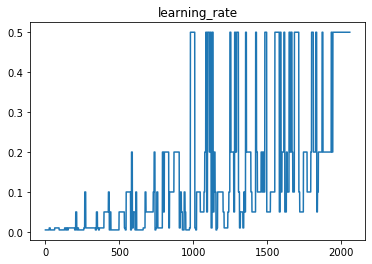

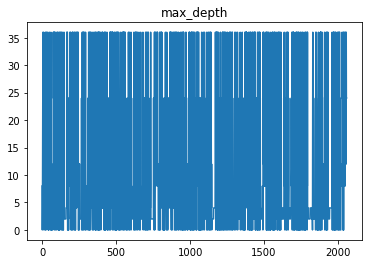

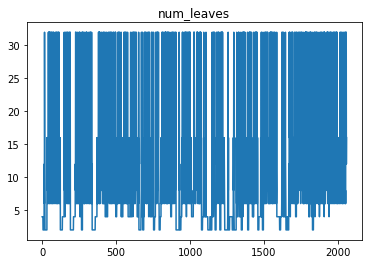

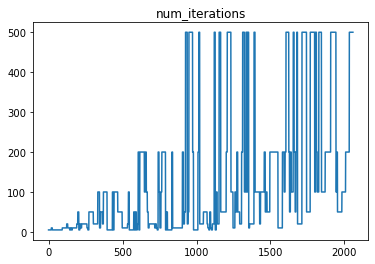

In [26]:
for key in df:
    if isinstance(df[key][0], list):
        continue
    if len(df[key].drop_duplicates()) == 1:
        continue
    plt.plot(df[key])
    plt.title(key)
    plt.show()

### Train best model

In [27]:
best_params = training_stats_df.iloc[0]["params"].copy()

In [28]:
gbm = lgb.train(best_params, lgb_full, valid_sets=[lgb_full], verbose_eval=0)

In [29]:
gbm.best_score

defaultdict(dict,
            {'training': {'l2': 3.055449129867617, 'l1': 1.3953261299919313}})

In [30]:
gbm.num_trees()

5

### Feature importances

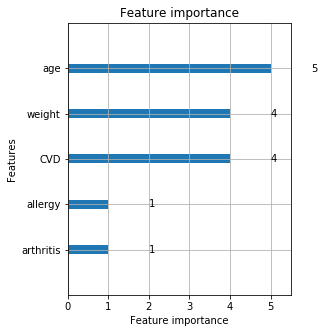

In [31]:
fg, ax = plt.subplots(figsize=(4, 5))

with plt.rc_context(rc={"font.size": 10}):
    lgb.plot_importance(gbm, ax=ax)
fg.savefig(NOTEBOOK_PATH / "feature-importance.svg", bbox_inches="tight")

### Cross-validation accuracy

In [32]:
actual = []
predicted = []

for lgb_train, lgb_test in lgb_train_test_splits:
    gbm_sub = lgb.train(
        best_params,
        lgb_train,
        valid_sets=[lgb_train, lgb_test],
        early_stopping_rounds=None,
        verbose_eval=0,
    )
    actual.append(lgb_test.label)
    predicted.append(gbm_sub.predict(lgb_test.data))
    
actual = np.hstack(actual)
predicted = np.hstack(predicted)

/home/ubuntu/anaconda3/envs/defaults-v1/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ubuntu/anaconda3/envs/defaults-v1/lib/python3.7/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


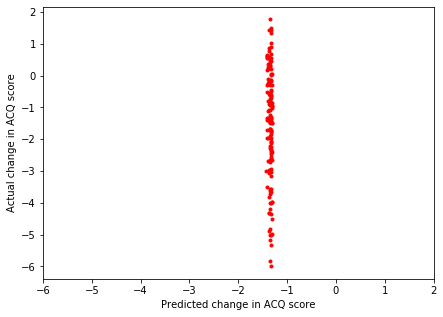

In [35]:
fg, ax = plt.subplots(figsize=(7, 5))

with plt.rc_context({"font.size": 12}):
    ax.set_xlabel("Predicted change in ACQ score")
    ax.set_ylabel("Actual change in ACQ score")
    ax.plot(predicted, actual, 'r.')
    ax.set_xlim(-6, 2)
    par = np.polyfit(predicted, actual, 1, full=True)